# Practice PS06: Recommendations engines (interactions-based)

Author: <font color="blue">Leticia Martín Cabrera</font>

E-mail: <font color="blue">leticia.martin03@estudiant.upf.edu</font>

Date: <font color="blue">09/11/2021</font>

# 0.1. Load the input files

In [1]:
# Leave this code as-is

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from math import*
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# Leave this code as-is

FILENAME_RATINGS = "data/ratings.dat"
FILENAME_USERS = "data/users.dat"
FILENAME_MOVIES = "data/movies.dat"

In [3]:
# Leave this code as-is

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep='::', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

users = pd.read_csv(FILENAME_USERS, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
_ = users.set_index('user_id')

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
_ = movies.set_index('movie_id')

# 0.2. Merge the data into a single dataframe

In [4]:
# joining the datasets into a single dataframe named "ratings"
ratings = pd.merge(ratings_raw, users, how='inner', on='user_id')
ratings = pd.merge(ratings, movies, how= 'inner', on = 'movie_id')
ratings.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zipcode,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [5]:
#create find_movies function
def find_movies(keyword, dataset):
    for movie in dataset['title']: 
        if keyword in movie:
            result = dataset['movie_id'][dataset['title'] == movie].iloc[0]  #obtaining movie_id of the selected movie 
            print("movie_id:", result, ", title:", movie ) 

# 1. Exploratory Data Analysis

## 1.1. Unique registers

In [6]:
#Calculate the number of unique users and unique movies
unique_users = len(ratings['user_id'].unique())
unique_movies = len(ratings['movie_id'].unique())
print("Number of users : ", unique_users)
print("Number of movies : ", unique_movies)


Number of users :  6040
Number of movies :  3706


## 1.2. Age differences in ratings

Text(0, 0.5, 'Rating')

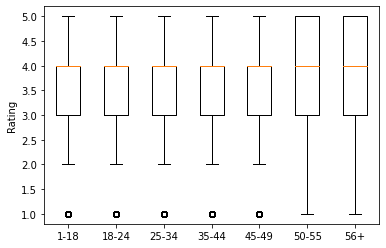

In [7]:
ages = [1,18, 25, 35, 45, 50, 56 ]
ratings_age = []
for i in ages:
    ratings_age.append(list(ratings.loc[ratings['age'] == i].rating))

labels_x = ['1-18','18-24', '25-34', '35-44', '45-49', '50-55','56+']
plt.boxplot(ratings_age,labels = labels_x)
plt.ylabel("Rating")

In view of the graph obtained, we can clearly differentiate two groups according to their similarity of opinions. The first group is between 18 and 49 years of age, whose interquartile range (central 50% of the ratings) is between 3 and 4, with a clear outlier at value 1. 

For the second group,whose age is from 50 years and older, we notice some more differences, in this case the range shows us all the possible scores (1-5), so for this age group we can conclude that there is a stricter opinion when evaluating the films, although it is also a group with a more varied opinion (greater dispersion) than the previous one mentioned.

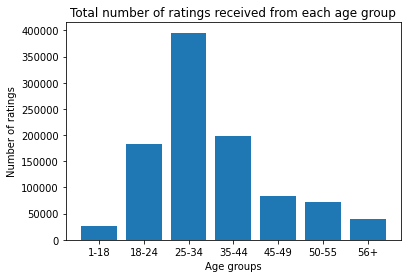

In [8]:
#We compute how many ratings there are for each group
#create an array with bins
bins_arr = ages
bins_arr.append(999) #Adding an element too be the upper limit of the las bin
hist_ratings = np.histogram(ratings['age'], bins = bins_arr)[0] 

#We plot a bar plot in which in the x axis you have the age groups and in the y axis the number of ratings from that age group
plt.bar(labels_x, hist_ratings )
plt.title("Total number of ratings received from each age group")
plt.xlabel("Age groups")
plt.ylabel("Number of ratings")
plt.show()

# 2. Item-based Collaborative Filtering

## 2.1. Data pre-processing

In [9]:
#Create the "rated_movies" dataset
rated_movies = ratings_raw.merge(movies, on = 'movie_id')
rated_movies = rated_movies.drop( ['timestamp', 'genres'], axis = 1) #Drop columns genres and timestamp
rated_movies.head()

,user_id,movie_id,rating,title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975)


In [10]:
#We create anew dataframe named ratings_summary
ratings_summary = rated_movies[['movie_id','title']].groupby('movie_id').first() #Initializing ratings_summary
#Compute ratings mean and count and add it to ratings_summary
ratings_summary['ratings_mean'] = rated_movies.groupby('movie_id')['rating'].mean()
ratings_summary['ratings_count'] = rated_movies.groupby('movie_id')['rating'].count()
ratings_summary.head()

,title,ratings_mean,ratings_count
movie_id,,,
1,Toy Story (1995),4.146846,2077
2,Jumanji (1995),3.201141,701
3,Grumpier Old Men (1995),3.016736,478
4,Waiting to Exhale (1995),2.729412,170
5,Father of the Bride Part II (1995),3.006757,296


In [11]:
#printing the top 10 highest rated movies, considering only movies receiving at least 1000 ratings.
ratings_summary[ratings_summary['ratings_count'] >= 1000].sort_values(by='ratings_mean', ascending = False).head(10)

,title,ratings_mean,ratings_count
movie_id,,,
318,"Shawshank Redemption, The (1994)",4.554558,2227
858,"Godfather, The (1972)",4.524966,2223
50,"Usual Suspects, The (1995)",4.517106,1783
527,Schindler's List (1993),4.510417,2304
1198,Raiders of the Lost Ark (1981),4.477725,2514
904,Rear Window (1954),4.476190,1050
260,Star Wars: Episode IV - A New Hope (1977),4.453694,2991
750,Dr. Strangelove or: How I Learned to Stop Worr...,4.449890,1367
912,Casablanca (1942),4.412822,1669


In [12]:
#printing the top 10 highest rated movies, considering only movies receiving at least 3 ratings.
ratings_summary[ratings_summary['ratings_count'] >= 3].sort_values(by='ratings_mean', ascending = False).head(10)

,title,ratings_mean,ratings_count
movie_id,,,
787,"Gate of Heavenly Peace, The (1995)",5.000000,3
3245,I Am Cuba (Soy Cuba/Ya Kuba) (1964),4.800000,5
53,Lamerica (1994),4.750000,8
2503,"Apple, The (Sib) (1998)",4.666667,9
2905,Sanjuro (1962),4.608696,69
2019,Seven Samurai (The Magnificent Seven) (Shichin...,4.560510,628
318,"Shawshank Redemption, The (1994)",4.554558,2227
858,"Godfather, The (1972)",4.524966,2223
745,"Close Shave, A (1995)",4.520548,657


Comparing both groups, we can see that with a number of ratings as low as 3, the result does not show any dispersion (all 3 ratings are 5 stars), nor does it provide reliability. The same is true for the following ratings.

Hence, it is much better to have a more extensive number of reviews that reflect the true value of this film in order to obtain a reliable and contrasting opinion of its worth.


## 2.2. Compute the user-movie matrix

In [13]:
#Create a "user_movie" matrix
user_movie = rated_movies.pivot_table(index= 'user_id', columns= 'movie_id', values= 'rating')
user_movie.head(10)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN


There are many 'NaN' values since there are many users who have not rated all the films. It is called sparsity since the rating model becomes very sparse which could lead to data sparsity problems, it decreases the possibilities of finding a set of users with similar ratings or interest

# 2.3. Explore some correlations in the user-movie matrix

In [14]:
#Locate the movie_id for 3 movies: Alien (1979), Planet of the Apes (1968) and Home Alone (1990)
find_movies('Alien (1979)', movies)
find_movies('Planet of the Apes (1968)', movies)
find_movies('Home Alone (1990)', movies)


movie_id: 1214 , title: Alien (1979)
movie_id: 2529 , title: Planet of the Apes (1968)
movie_id: 586 , title: Home Alone (1990)


In [15]:
#Obtain the ratings for each of these movies
s1 = user_movie[1214].dropna()
s2 = user_movie[2529].dropna()
s3 = user_movie[586].dropna()

#consolidate these three series into a single dataframe
ratings3 = pd.concat([s1, s2, s3], axis=1)
#Drop from ratings3 all rows containing a NaN
ratings3 = ratings3.dropna()

ratings3.head(10)#print the first 10 rows


,1214,2529,586
user_id,,,
10,4.0,4.0,3.0
33,4.0,5.0,4.0
48,3.0,3.0,4.0
166,5.0,5.0,3.0
198,3.0,4.0,5.0
216,4.0,2.0,4.0
245,4.0,4.0,1.0
264,3.0,3.0,3.0
284,4.0,3.0,3.0


In [16]:
#Compute Pearson correlation between the three movies and print the resuts
print("Similarity between 'Alien (1979)' and 'Planet of the Apes (1968)':", "{:.2f}".format(ratings3[1214].corr(ratings3[2529])))
print("Similarity between 'Alien (1979)' and 'Home Alone (1990)':", "{:.2f}".format(ratings3[1214].corr(ratings3[586])))
print("Similarity between 'Planet of the Apes (1968)' and 'Home Alone (1990)':", "{:.2f}".format(ratings3[2529].corr(ratings3[586])))

Similarity between 'Alien (1979)' and 'Planet of the Apes (1968)': 0.31
Similarity between 'Alien (1979)' and 'Home Alone (1990)': 0.06
Similarity between 'Planet of the Apes (1968)' and 'Home Alone (1990)': 0.24


We can observe that there is no strong correlation between all variables. For Alien and Home Alone movies we can say that there is no relation since the correlation is almost 0. The others two correlations (Alien and Planet of the Apes, Planet of the Apes and Home ALone) are higher but these values are lower enough to say the pattern are not significant at all.

In [17]:
#create a "similar_to_alien" series that contains the computed correlations
similar_to_alien =  user_movie.corrwith(user_movie[1214], axis = 0, method='pearson').dropna()
similar_to_alien

C:\Users\letic\anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\letic\anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


movie_id
1       0.171476
2       0.137267
3      -0.031216
4       0.078568
5       0.200375
          ...   
3948    0.132357
3949    0.092359
3950    0.476339
3951   -0.131081
3952   -0.001330
Length: 3412, dtype: float64

In [18]:
#Create a corr_with_alien dataframe
corr_with_alien = pd.DataFrame(similar_to_alien, columns=['corr'])
corr_with_alien = pd.merge(ratings_summary,corr_with_alien, how ='inner', on= 'movie_id').sort_values('corr',ascending=False)

#Create a new dataset selecting only the movies that have more than 500 ratings 
corr_with_alien_500 = corr_with_alien[corr_with_alien['ratings_count'] > 500]
corr_with_alien_500.head(10) #print the 10 movies with highest correlation

,title,ratings_mean,ratings_count,corr
movie_id,,,,
1214,Alien (1979),4.159585,2024,1.000000
1200,Aliens (1986),4.125824,1820,0.543713
1997,"Exorcist, The (1973)",3.955932,885,0.429366
1387,Jaws (1975),4.089570,1697,0.411834
1240,"Terminator, The (1984)",4.152050,2098,0.398378
2455,"Fly, The (1986)",3.440710,1071,0.372014
3703,Mad Max 2 (a.k.a. The Road Warrior) (1981),3.674081,1034,0.367116
45,To Die For (1995),3.424632,544,0.366898
2160,Rosemary's Baby (1968),3.818820,712,0.348599


In [19]:
#print the first 10 movies more correlated with "Alien" movie (without the limit of ratings_count > 500)
corr_with_alien

,title,ratings_mean,ratings_count,corr
movie_id,,,,
2200,Under Capricorn (1949),2.500000,8,1.0
3772,Hatchet For the Honeymoon (Rosso Segno Della F...,1.666667,3,1.0
3875,"Devil Rides Out, The (1968)",2.800000,5,1.0
981,Dangerous Ground (1997),2.750000,4,1.0
2960,Beefcake (1999),2.750000,4,1.0
...,...,...,...,...
2198,Modulations (1998),4.000000,2,-1.0
703,Boys (1996),1.600000,10,-1.0
2833,Lucie Aubrac (1997),3.666667,6,-1.0


In [20]:
#Create a new dataset selecting only the movies that have more than 200 ratings 
corr_with_alien_200 = corr_with_alien[corr_with_alien['ratings_count'] > 200]
corr_with_alien_200.head(10) #print the 10 movies with highest correlation

,title,ratings_mean,ratings_count,corr
movie_id,,,,
1214,Alien (1979),4.159585,2024,1.000000
1200,Aliens (1986),4.125824,1820,0.543713
1997,"Exorcist, The (1973)",3.955932,885,0.429366
1387,Jaws (1975),4.089570,1697,0.411834
1240,"Terminator, The (1984)",4.152050,2098,0.398378
3018,Re-Animator (1985),3.475806,248,0.375170
2454,"Fly, The (1958)",3.358333,480,0.374341
2455,"Fly, The (1986)",3.440710,1071,0.372014
3703,Mad Max 2 (a.k.a. The Road Warrior) (1981),3.674081,1034,0.367116


In [21]:
#Create a new dataset selecting only the movies that have more than 100 ratings 
corr_with_alien_100 = corr_with_alien[corr_with_alien['ratings_count'] > 100]
corr_with_alien_100.head(10) #print the 10 movies with highest correlation

,title,ratings_mean,ratings_count,corr
movie_id,,,,
1214,Alien (1979),4.159585,2024,1.000000
1200,Aliens (1986),4.125824,1820,0.543713
1840,He Got Game (1998),3.381250,160,0.446851
3406,Captain Horatio Hornblower (1951),3.752381,105,0.440847
1997,"Exorcist, The (1973)",3.955932,885,0.429366
1387,Jaws (1975),4.089570,1697,0.411834
2166,Return to Paradise (1998),3.520833,144,0.405951
1240,"Terminator, The (1984)",4.152050,2098,0.398378
1366,"Crucible, The (1996)",3.185185,108,0.398304


If we remove the restriction of a minimum number of ratings, we see how it is much more likely that the ratings of the few users who have given their opinion coincide, so that the correlation coefficient will be the same for many of them. Hence we can observe so many perfect correlations (+-)1, a ratio that obviously decreases as the number of ratings increases and the dissimilarity between them.

# 2.4. Implement the item-based recommendations

In [22]:
#compute all correlations between movies in the matrix user_movie
item_similarity = user_movie.corr()
item_similarity.head(5)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.187467,0.160649,0.348759,0.156957,0.051097,0.149536,0.151248,-0.039358,0.143598,...,-0.099845,0.174078,0.146344,0.135146,0.431743,0.139323,0.189518,0.146536,0.324325,0.157996
2,0.187467,1.000000,0.149349,0.057874,0.384293,0.075067,0.251093,0.312949,0.407857,0.254558,...,0.009798,-1.000000,0.276240,0.133538,0.042524,0.216196,0.082241,-0.154672,-0.353553,0.073111
3,0.160649,0.149349,1.000000,0.261800,0.399532,0.156934,0.220211,0.394405,0.151163,0.269250,...,-0.134059,0.239046,-0.361158,0.205521,-0.024042,0.314249,0.026743,0.445399,NaN,0.110024
4,0.348759,0.057874,0.261800,1.000000,0.401954,-0.012096,0.097271,0.074080,-0.681895,0.010868,...,0.589662,NaN,NaN,0.158114,-0.500000,0.209258,-0.434783,0.500000,0.000000,0.154463
5,0.156957,0.384293,0.399532,0.401954,1.000000,0.075755,0.276160,0.589313,0.538139,0.241397,...,-0.533114,0.188982,NaN,0.522037,0.960769,0.416291,-0.133077,0.650000,NaN,-0.033736


In [23]:
#compute all correlations between movies in the matrix user_movie, considering only movies having at least 100 ratings in common
item_similarity_min_ratings = user_movie.corr(min_periods=100)
item_similarity_min_ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.187467,0.160649,0.348759,0.156957,0.051097,0.149536,NaN,NaN,0.143598,...,NaN,NaN,NaN,NaN,NaN,0.139323,0.189518,NaN,NaN,0.157996
2,0.187467,1.000000,0.149349,NaN,0.384293,0.075067,0.251093,NaN,NaN,0.254558,...,NaN,NaN,NaN,NaN,NaN,0.216196,NaN,NaN,NaN,NaN
3,0.160649,0.149349,1.000000,NaN,0.399532,0.156934,0.220211,NaN,NaN,0.269250,...,NaN,NaN,NaN,NaN,NaN,0.314249,NaN,NaN,NaN,NaN
4,0.348759,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.156957,0.384293,0.399532,NaN,1.000000,NaN,0.276160,NaN,NaN,0.241397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#Obtain the ids of two users, one who liked the three romantic films, and another one who liked the three science fiction films
user_id_rom = user_movie.index[(user_movie[587] >= 4) & (user_movie[1088] >= 4) & (user_movie[3257] >= 4)][0]
user_id_sci = user_movie.index[(user_movie[1214] >= 4) & (user_movie[3527] >= 4) & (user_movie[260] >= 4)][0]

In [42]:
# Leave this code as-is

# Gets a list of watched movies for a user_id
def get_watched_movies(user_id, user_movie):
    return list(user_movie.loc[user_id].dropna().index)
    
# Gets the title of a movie by movie_id
def get_title(movie_id, movies):
    return movies[movies['movie_id'] == movie_id].title.iloc[0]

# Gets the rating a user_id has given to a movie_id
def get_rating(user_id, movie_id, user_movie):
    return user_movie[movie_id][user_id]

# Print watched movies
def print_watched_movies(user_id, user_movie, movies):
    for movie_id in get_watched_movies(user_id, user_movie):
        print("%d %.1f %s " %
          (movie_id, get_rating(user_id, movie_id, user_movie), get_title(movie_id, movies)))

# Test functions
print_watched_movies(user_id_rom, user_movie, movies)

1 5.0 Toy Story (1995) 
2 5.0 Jumanji (1995) 
3 4.0 Grumpier Old Men (1995) 
15 3.0 Cutthroat Island (1995) 
24 5.0 Powder (1995) 
31 3.0 Dangerous Minds (1995) 
34 4.0 Babe (1995) 
60 3.0 Indian in the Cupboard, The (1995) 
95 4.0 Broken Arrow (1996) 
104 3.0 Happy Gilmore (1996) 
110 3.0 Braveheart (1995) 
135 4.0 Down Periscope (1996) 
150 4.0 Apollo 13 (1995) 
151 1.0 Rob Roy (1995) 
153 3.0 Batman Forever (1995) 
158 3.0 Casper (1995) 
168 4.0 First Knight (1995) 
170 5.0 Hackers (1995) 
174 3.0 Jury Duty (1995) 
188 5.0 Prophecy, The (1995) 
193 3.0 Showgirls (1995) 
208 4.0 Waterworld (1995) 
231 5.0 Dumb & Dumber (1994) 
253 5.0 Interview with the Vampire (1994) 
266 1.0 Legends of the Fall (1994) 
288 1.0 Natural Born Killers (1994) 
292 5.0 Outbreak (1995) 
316 1.0 Stargate (1994) 
317 3.0 Santa Clause, The (1994) 
325 2.0 National Lampoon's Senior Trip (1995) 
329 3.0 Star Trek: Generations (1994) 
344 3.0 Ace Ventura: Pet Detective (1994) 
353 4.0 Crow, The (1994) 
356 5.0 

In [43]:
def get_movies_relevance(user_id, user_movie, item_similarity_matrix):

    # Create an empty series
    movies_relevance =pd.Series()

    # Iterate through the movies the user has watched
    for watched_movie in get_watched_movies(user_id, user_movie):

        # Obtain the rating given
        rating_given = get_rating(user_id, watched_movie, user_movie)

        # Obtain the vector containing the similarities of watched_movie
        # with all other movies in item_similarity_matrix
        similarities = item_similarity_matrix[watched_movie]

        # Multiply this vector by the given rating
        weighted_similarities = rating_given*similarities

        # Append these terms to movies_relevance
        movies_relevance = movies_relevance.append(weighted_similarities)

    # Compute the sum for each movie
    movies_relevance = movies_relevance.groupby(movies_relevance.index).sum()

    # Convert to a dataframe
    movies_relevance_df = pd.DataFrame(movies_relevance, columns=['relevance'])
    movies_relevance_df['movie_id'] = movies_relevance_df.index

    return movies_relevance_df

In [44]:
#Obtain the relevant movies for the user_id_rom
movies_relevance_rom = get_movies_relevance(user_id_rom, user_movie, item_similarity_min_ratings)

#We merge the dataframe movies_relevance_rom with the movies dataframe on the movie_id attribute.
movies_relevance_rom = pd.merge(movies_relevance_rom, movies, how = 'inner', on='movie_id')

#Sort the results by descending relevance and print the top 10 for each case
movies_relevance_rom.sort_values('relevance', ascending=False).head(10)

C:\Users\letic\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,relevance,movie_id,title,genres
1821,215.550553,2001,Lethal Weapon 2 (1989),Action|Comedy|Crime|Drama
3351,213.569940,3591,Mr. Mom (1983),Comedy|Drama
699,213.108751,733,"Rock, The (1996)",Action|Adventure|Thriller
1029,212.764319,1101,Top Gun (1986),Action|Romance
1822,208.131512,2002,Lethal Weapon 3 (1992),Action|Comedy|Crime|Drama
737,208.085978,780,Independence Day (ID4) (1996),Action|Sci-Fi|War
780,206.725108,832,Ransom (1996),Drama|Thriller
486,206.341654,500,Mrs. Doubtfire (1993),Comedy
573,203.767493,587,Ghost (1990),Comedy|Romance|Thriller
2277,203.717111,2470,Crocodile Dundee (1986),Adventure|Comedy


In [46]:
#Obtain the relevant movies for the user_id_sci
movies_relevance_sci = get_movies_relevance(user_id_sci, user_movie, item_similarity_min_ratings)

#We merge the dataframe movies_relevance_sci with the movies dataframe on the movie_id attribute.
movies_relevance_sci = pd.merge(movies_relevance_sci, movies, how = 'inner', on='movie_id')

#Sort the results by descending relevance and print the top 10 for each case
movies_relevance_sci.sort_values("relevance", ascending=False).head(10)

C:\Users\letic\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,relevance,movie_id,title,genres
2438,150.071603,2640,Superman (1978),Action|Adventure|Sci-Fi
2214,148.695014,2407,Cocoon (1985),Comedy|Sci-Fi
1831,147.209982,2011,Back to the Future Part II (1989),Comedy|Sci-Fi
1050,146.394968,1127,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller
2592,145.561288,2797,Big (1988),Comedy|Fantasy
578,143.260151,592,Batman (1989),Action|Adventure|Crime|Drama
1594,143.216386,1748,Dark City (1998),Film-Noir|Sci-Fi|Thriller
954,142.388045,1019,"20,000 Leagues Under the Sea (1954)",Adventure|Children's|Fantasy|Sci-Fi
1276,141.223326,1375,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi
3238,140.638966,3471,Close Encounters of the Third Kind (1977),Drama|Sci-Fi


For the first user, we can observe that there are not many romantic films. Despite that, reading the plot of the film we can know that in many of these films there is a love story but it is not the main theme of the films. In conclusion, I think that Ghost and Top Gun are the most representative ones for our user.

For the second user, all movies look relevant except 'Big (1988)' since is not a science fiction film. Batman is also not consider a science fiction movie but in my opionion it is. Hence, We can include it as a relevant flim.

In [48]:
def get_recommended_movies (user_id, user_movie, item_similarity_matrix):
    
    #Obtain the dataframe of relevant movies with get_movies_relevance
    relevant_movies = get_movies_relevance(user_id, user_movie, item_similarity_matrix) 
    
    #Set this dataframe index to 'movie_id'
    relevant_movies = relevant_movies.set_index('movie_id', drop=True, append=False, inplace=False, verify_integrity=False) 
    
    #Obtain the list of movie_ids of watched movies with get_watched_movies
    movies_watched = get_watched_movies(user_id, user_movie) 
    
    #Drop from the relevant movies dataframe the watched movies
    recommended_movies = relevant_movies.drop(movies_watched)  
    
    return recommended_movies

In [53]:
#Obtain the recommended movies for the user_id_rom
recommended_movies_rom = get_recommended_movies(user_id_rom, user_movie, item_similarity_min_ratings)

#Create new dataset merging the relevant movies and movies datasframes
recommended_movies_rom = pd.merge(recommended_movies_rom, movies,on='movie_id') 
    
#sort the recommended_movies by relevance
recommended_movies_rom = recommended_movies_rom.sort_values("relevance", ascending=False) 

recommended_movies_rom.head(10)

C:\Users\letic\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,movie_id,relevance,title,genres
1675,2001,215.550553,Lethal Weapon 2 (1989),Action|Comedy|Crime|Drama
3108,3591,213.569940,Mr. Mom (1983),Comedy|Drama
1683,2011,203.658654,Back to the Future Part II (1989),Comedy|Sci-Fi
1172,1370,201.659062,Die Hard 2 (1990),Action|Thriller
2663,3107,198.761397,Backdraft (1991),Action|Drama
1674,2000,197.201010,Lethal Weapon (1987),Action|Comedy|Crime|Drama
1594,1918,195.271820,Lethal Weapon 4 (1998),Action|Comedy|Crime|Drama
1911,2268,194.721372,"Few Good Men, A (1992)",Crime|Drama
1986,2353,193.499950,Enemy of the State (1998),Action|Thriller
160,185,193.374547,"Net, The (1995)",Sci-Fi|Thriller


In [54]:
#Obtain the recommended movies for the user_id_sci
recommended_movies_sci = get_recommended_movies(user_id_sci, user_movie, item_similarity_min_ratings)

#Create new dataset merging the relevant movies and movies datasframes
recommended_movies_sci = pd.merge(recommended_movies_sci, movies,on='movie_id') 
    
#sort the recommended_movies by relevance
recommended_movies_sci = recommended_movies_sci.sort_values("relevance", ascending=False) 

recommended_movies_sci.head(10)

C:\Users\letic\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,movie_id,relevance,title,genres
2438,2797,145.561288,Big (1988),Comedy|Fantasy
542,592,143.260151,Batman (1989),Action|Adventure|Crime|Drama
1198,1375,141.223326,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi
1878,2174,138.760871,Beetlejuice (1988),Comedy|Fantasy
2148,2470,135.846914,Crocodile Dundee (1986),Adventure|Comedy
1765,2054,135.789896,"Honey, I Shrunk the Kids (1989)",Adventure|Children's|Comedy|Fantasy|Sci-Fi
3164,3591,134.824006,Mr. Mom (1983),Comedy|Drama
1199,1377,131.706370,Batman Returns (1992),Action|Adventure|Comedy|Crime
3037,3448,131.400804,"Good Morning, Vietnam (1987)",Comedy|Drama|War
2049,2366,128.427217,King Kong (1933),Action|Adventure|Horror


In the list of recommended movies for the first user we can observe that there is not any romantic film. So we consider all movies irrelevant.

In the list of recommended movies for the second user there are more irrelevant than in the results obtained before removing the wathched movies. It is due to so many science fiction film have disappeared. 

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>